In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.backend import relu
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import random
import seaborn as sns
import itertools
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50

In [1]:
#Load dataset
(xtrain, ytrain), (xtest, ytest)=cifar10.load_data()

NameError: ignored

In [ ]:
#Vectorize input (e.g. [[1,2],[3,4]] -->[1,2,3,4])
(xtrain,xtest)=(np.reshape(xtrain,(50000,32*32*3)),np.reshape(xtest,(10000,32*32*3)))

In [ ]:
#Normalized input
xtrain_norm=xtrain/255
xtest_norm=xtest/255

In [ ]:
#Vectorize output (e.g. 5 --> [0,0,0,0,0,1,0,0,0,0])
ytrain_vector=np.zeros((50000,10))
for i in range(50000):
  ytrain_vector[i,ytrain[i]]=1

ytest_vector=np.zeros((10000,10))
for i in range(10000):
  ytest_vector[i,ytest[i]]=1


In [ ]:
#Define softmax activation function
def softmax(z):
  #Change data type to avoid overflow
  z=np.array(z, dtype=np.float128)
  
  #Compute softmax of each class
  return np.exp(z-np.max(z))/sum(np.exp(z-np.max(z)))


def softmax_pred(z):
  #Change data type to avoid overflow
  z=np.array(z, dtype=np.float128)
  
  #Compute softmax of each class
  x=np.exp(z-np.max(z))/sum(np.exp(z-np.max(z)))
  
  max_prob=0
  max_index=-1
  #Check which class has the highest probabiity
  for i in range(len(x)):
    if x[i]>max_prob:
      max_index=i
      max_prob=x[i]
  #Return predicted class
  return max_index

logistic = lambda z: 1./ (1 + np.exp(-z))

tanh = lambda z: np.tanh(z)

def leaky_relu(a):
    z=np.copy(a)
    for i in range(len(z)):
        for j in range(len(z[i])):
            x = z[i][j]
            if x < 0:
                z[i][j] = 0.5*x
            else:
                continue
        
    return z


def leaky_relu_derivative(a):
    z=np.copy(a)
    for i in range(len(z)):
        for j in range(len(z[i])):
            x = z[i][j]
            if x > 0:
                z[i][j] = 1
            else:
                z[i][j] = 0.5
    return z





In [ ]:
class mlp:
  def __init__(self,activation_fn=relu,layers=2,units=[64,64],add_bias=False):
    self.add_bias=add_bias
    self.activation_fn=activation_fn
    self.layers=layers
    self.units=units
    self.history = []
    
    #Check that there is the correct number of layers
    if len(units)!=layers:
      raise Exception("Units should have same length as number of layers")
    
    
    self.weights=[]
    current=3072
    for i in units:
      #Initialize weights randomly
      matrix=np.random.randn(current+add_bias,i)*0.1
      self.weights.append(matrix)
      current=i
    #Add last connection to output layer
    self.weights.append(np.random.randn(current+add_bias,10)*0.1)

    if self.activation_fn==logistic:
      self.derivative=lambda z: z * (1 - z)
 
    elif self.activation_fn==tanh:
      self.derivative=lambda z: 1-z**2 

    elif self.activation_fn==relu:
      self.derivative=lambda z: np.array((z>0),dtype=np.uint8)
    
    elif self.activation_fn==leaky_relu:
      self.derivative=lambda z: leaky_relu_derivative(z) #if element of z is positive then 1 otherwise 0.5

  #--------------------------------------------------------------------------------
  def fit(self, x=xtrain_norm, y=ytrain_vector,learning_rate=.001, max_iters=1e4, epsilon=1e-8,batchsize=10,reg1=0,reg2=0):
    #Implementation of backpropagation
    def gradient(x, y, weights): #TODO
      N,D = x.shape
      if self.add_bias:
        x=np.column_stack([x,np.ones(x.shape[0])])

      if self.layers==0:
        w=self.weights[0]
        yh=np.apply_along_axis(softmax, 1, x@w)
        dy=yh-y
        dw=(x.T @ dy)/N

        return dw
#------------------------------------------------------------------------------
      elif self.layers==1:
        v,w=self.weights
        z = self.activation_fn(np.dot(x, v))#N x M
        if self.add_bias:
          zs=np.column_stack([z,np.ones(N)])
        else:
          zs=z
        
        yh=np.apply_along_axis(softmax, 1, np.dot(zs, w))
        
        dy = yh - y #N x C
        dw= np.dot(np.array(zs).T, dy)/N #M x C
        
        dz = np.dot(dy, w.T)* self.derivative(zs) #N x M
        dv = np.dot(x.T, dz[:,:dz.shape[1]-self.add_bias]) #D x M
        
        return dv,dw        
#------------------------------------------------------------------------------
      elif self.layers==2:
        u,v,w=self.weights

        z1=self.activation_fn(np.dot(x, u))#N x M1
        
        if self.add_bias:
          z1s=np.column_stack([z1,np.ones(N)])
        else:
          z1s=z1
        
        z2=self.activation_fn(np.dot(z1s, v))#N x M2
        if self.add_bias:
          z2s=np.column_stack([z2,np.ones(N)])
        else:
          z2s=z2

        yh=np.apply_along_axis(softmax, 1, np.dot(z2s, w))
        
        dy = yh - y #N x C  
        
        dw= np.dot(np.array(z2s).T, dy)/N#M2 x D
        
        dz2=np.dot(dy, w.T)* self.derivative(z2s) #N x M2    
        
        dv = np.dot(np.array(z1s).T, dz2[:,:dz2.shape[1]-self.add_bias] )/N #M1 x M2

        dz1=np.dot(dz2[:,:dz2.shape[1]-self.add_bias], v.T)* self.derivative(z1s) #N x M1 
        
        du=np.dot(x.T, dz1[:,:dz1.shape[1]-self.add_bias] )/N #D x M1

        return du,dv,dw
#------------------------------------------------------------------------------
      elif self.layers==3:
        t,u,v,w=self.weights
        
        z1=self.activation_fn(np.dot(x, t))#N x M1
        
        if self.add_bias:
          z1s=np.column_stack([z1,np.ones(N)])
        else:
          z1s=z1
        
        z2=self.activation_fn(np.dot(z1s, u))#N x M2
        if self.add_bias:
          z2s=np.column_stack([z2,np.ones(N)])
        else:
          z2s=z2
        
        z3=self.activation_fn(np.dot(z2s, v))#N x M2
        if self.add_bias:
          z3s=np.column_stack([z3,np.ones(N)])
        else:
          z3s=z3

        yh=np.apply_along_axis(softmax, 1, np.dot(z3s, w))
        dy = yh - y #N x C  

        dw= np.dot(np.array(z3s).T, dy)/N#M2 x D

        dz3=np.dot(dy, w.T)* self.derivative(z3s) #N x M2
        dv = np.dot(np.array(z2s).T, dz3[:,:dz3.shape[1]-self.add_bias] )/N

        dz2=np.dot(dz3[:,:dz3.shape[1]-self.add_bias], v.T)* self.derivative(z2s)
        du=np.dot(z1s.T, dz2[:,:dz2.shape[1]-self.add_bias] )/N

        dz1=np.dot(dz2[:,:dz2.shape[1]-self.add_bias], u.T)* self.derivative(z1s)
        dt=np.dot(x.T, dz1[:,:dz1.shape[1]-self.add_bias] )/N
        return dt,du,dv,dw

      else:
        raise Exception("Too many layers")

    #Define gradient descent
    optimizer=GradientDescent(learning_rate,max_iters,epsilon,batchsize,reg1,reg2)
    #Fit the mdoel
    self.weights, self.history = optimizer.run(gradient, x, y, self)
    return self
    
  def predict(self,x):
    #Add bias to x
    if self.add_bias:
      x=np.column_stack([x,np.ones(x.shape[0])])
    z=x

    for i in self.weights[:-1]:
      z=self.activation_fn(z@i)
      if self.add_bias:
        z=np.column_stack([z,np.ones(x.shape[0])])
    #Softmax classification
    return np.apply_along_axis(softmax_pred, 1, z@self.weights[-1])


In [ ]:
class GradientDescent:
  def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8,batchsize=1,reg1=0,reg2=0):
    self.learning_rate = learning_rate
    self.max_iters = max_iters
    self.epsilon = epsilon
    self.batchsize=batchsize
    self.reg1=reg1
    self.reg2=reg2
  
  
  def run(self, gradient_fn, x, y, mlp):#TODO
    norms = np.array([np.inf])
    t = 1

    history = [[],[]]

    while np.any(norms > self.epsilon) and t < self.max_iters:
        if not np.any(norms > self.epsilon):
        #Random stochastic batch
        r=random.sample(range(x.shape[0]), self.batchsize)
        x_batch=x[tuple([r])]
        y_batch=y[tuple([r])]
        grad = gradient_fn(x_batch, y_batch, mlp.weights)
        
        #Reduce learning rate to take smaller steps
        if t>6000:
          self.learning_rate=0.01
        for p in range(len(mlp.weights)):
            mlp.weights[p] -= self.learning_rate * grad[p]
            
            #L1 and L2 regularization
            if self.reg1>0 or self.reg2>0:
              mlp.weights[p] -=self.reg1*np.abs(mlp.weights[p])+self.reg2*mlp.weights[p]**2

            
        t += 1
        if t%1000==0:
          
          print(t,evaluate_acc(xtest_norm,ytest,mlp))
          history[0].append(t)
          history[1].append(evaluate_acc(xtest_norm,ytest,mlp))
          
        norms = np.array([np.linalg.norm(g) for g in grad])
    return mlp.weights, history


In [ ]:
def evaluate_acc(x,ytrue,mlp):
  ypred=mlp.predict(x)
  return accuracy_score(ytrue,ypred)

In [ ]:
#Best Batch Size
yplot = []

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/8,batchsize=8, learning_rate = 0.1)
print(evaluate_acc(xtest_norm,ytest,model))
yplot.append(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/16,batchsize=16, learning_rate = 0.1)
print(evaluate_acc(xtest_norm,ytest,model))
yplot.append(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/32,batchsize=32, learning_rate = 0.1)
print(evaluate_acc(xtest_norm,ytest,model))
yplot.append(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/64,batchsize=64, learning_rate = 0.1) #best batch size
print(evaluate_acc(xtest_norm,ytest,model))
yplot.append(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/128,batchsize=128, learning_rate = 0.1) #2nd best
print(evaluate_acc(xtest_norm,ytest,model))
yplot.append(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/256,batchsize=256, learning_rate = 0.1) #3rd best
print(evaluate_acc(xtest_norm,ytest,model))
yplot.append(evaluate_acc(xtest_norm,ytest,model))

In [ ]:
#Best Learning Rate
model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/64,batchsize=64, learning_rate = 0.0001)
a = model.history
print(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/64,batchsize=64, learning_rate = 0.001)
b = model.history
print(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/64,batchsize=64, learning_rate = 0.01) 
c = model.history
print(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/64,batchsize=64, learning_rate = 0.1) 
d = model.history
print(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[64, 64],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=256000/64,batchsize=64, learning_rate = 0.25) 
e = model.history
print(evaluate_acc(xtest_norm,ytest,model))

In [ ]:
lrs=[(a,"0.0001"),(b,"0.001"),(c,"0.01"),(d,"0.1"),(e,"0.25")]

for lr in lrs:
  x=lr[0][0]
  y=lr[0][1]
  plt.plot(x, y, label = lr[1])

plt.title('Learning rate Effects on Accuracy')
plt.xlabel('iterations')
plt.ylabel('accuracy')

leg = plt.legend(loc='lower left')
plt.show()

In [ ]:
#Expermient 1 #need graph (1 graph 3 lines)
model=mlp(layers=0,units=[],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64, learning_rate = 0.01)
ax = model.history[0]
ay = model.history[1]
print(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=1,units=[256],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64, learning_rate = 0.01)
bx = model.history[0]
by = model.history[1]
print(evaluate_acc(xtest_norm,ytest,model))

model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64, learning_rate = 0.01)
cx = model.history[0]
cy = model.history[1]
print(evaluate_acc(xtest_norm,ytest,model))

1000 0.1147
2000 0.1142
3000 0.1126
4000 0.1088
5000 0.1001
6000 0.1194
7000 0.1141
8000 0.1137
9000 0.119
10000 0.1139
0.1139
1000 0.2758
2000 0.326
3000 0.3291
4000 0.392
5000 0.3888
6000 0.371
7000 0.4084
8000 0.4149
9000 0.425
10000 0.434
0.434
1000 0.3771
2000 0.4061
3000 0.42
4000 0.4272
5000 0.4416
6000 0.4602
7000 0.4573
8000 0.4583
9000 0.4772
10000 0.4676
0.4676


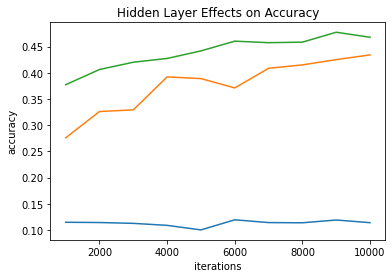

In [ ]:
plt.plot(ax,ay, label='no hidden layers')
plt.plot(bx,by, label='1 hidden layer')
plt.plot(cx,cy, label='2 hidden layer')
plt.title('Hidden Layer Effects on Accuracy')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()


In [ ]:
#Expermiment 2 (Bar Graph with 3)
model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=tanh)
model.fit(max_iters=10000,batchsize=64, learning_rate = 0.1)
x = evaluate_acc(xtest_norm,ytest,model)

model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=leaky_relu)
model.fit(max_iters=10000,batchsize=64,learning_rate = 0.1)
y = evaluate_acc(xtest_norm,ytest,model)

model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64,learning_rate = 0.1)
z = evaluate_acc(xtest_norm,ytest,model)

1000 0.4064
2000 0.4391
3000 0.376
4000 0.4405
5000 0.4721
6000 0.4609
7000 0.5027
8000 0.505
9000 0.5074
10000 0.506
1000 0.3701
2000 0.3876
3000 0.4089
4000 0.4283
5000 0.4202
6000 0.4352
7000 0.4517
8000 0.4432
9000 0.4555
10000 0.4516
1000 0.3722
2000 0.4085
3000 0.4224
4000 0.4479
5000 0.4468
6000 0.4675
7000 0.5009
8000 0.5001
9000 0.5021
10000 0.5034


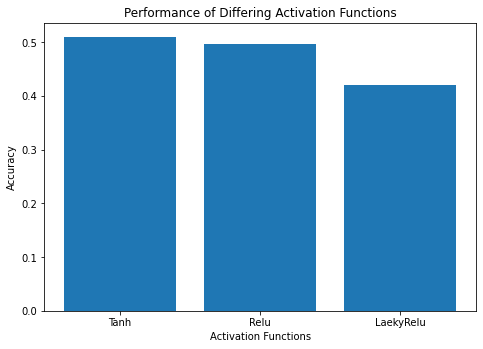

In [ ]:
xplot = ['Tanh', 'Relu', 'LaekyRelu']
yplot = [x, z, y]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(xplot,yplot)

plt.xlabel("Activation Functions")
plt.ylabel("Accuracy")
plt.title("Performance of Differing Activation Functions")
plt.show()

In [ ]:
model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=leaky_relu)
model.fit(max_iters=10000,batchsize=10,learning_rate = 0.01)
y = evaluate_acc(xtest_norm,ytest,model)

1000 0.2981
2000 0.3711
3000 0.3734
4000 0.3619
5000 0.3929
6000 0.4064
7000 0.3851
8000 0.3992
9000 0.4123
10000 0.4207


In [ ]:
data = {'tanh':x, 'leaky_relu':y, 'relu':z}
a = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(a, values, color ='maroon', width = 0.4)
 

plt.ylabel("Accuracy")
plt.title("Activation_fn on the model with 2 hidden layers")
plt.show()

In [ ]:
#Experiment 3
model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64,reg1=0.001,learning_rate=0.01)
x = evaluate_acc(xtest_norm,ytest,model)

model=mlp(layers=2,units=[256,256],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64,reg2=0.001,learning_rate=0.01)
y = evaluate_acc(xtest_norm,ytest,model)

In [ ]:
#Experiment 4 (Not Normalized vs Normalized)
model=mlp(layers=2,units=[256, 256],add_bias=True,activation_fn=relu)
model.fit(x=xtrain,max_iters=10000,batchsize=64, learning_rate = 0.1)
print(evaluate_acc(xtest,ytest,model))

model=mlp(layers=2,units=[256, 256],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=10000,batchsize=64, learning_rate = 0.1)
print(evaluate_acc(xtest_norm,ytest,model))

In [ ]:
#Experiment 5

#LOADING DATASET
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(256, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# a softmax classifier
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

history = model.fit(x_train, y_train,batch_size=64,epochs=25,validation_data=(x_test, y_test),shuffle=True)

%matplotlib inline
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()
# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [ ]:
#Experiment 6

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

base_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

historyRes = base_model.fit(x_train, y_train,batch_size=64,epochs=25,validation_data=(x_test, y_test),shuffle=True)

plt.plot((historyRes.history['accuracy']), label='no hidden layers')

plt.title('Pretrained Model on CIFAR10')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
#Experiment Special Project Part 1(3 hidden layers)
model=mlp(layers=3,units=[256, 256, 256],add_bias=True,activation_fn=relu)
model.fit(max_iters=10000,batchsize=64, learning_rate = 0.01)
print(evaluate_acc(xtest_norm,ytest,model))

In [ ]:
#Experiment Special Project Part 2 (Standardized Datset vs Normalized Dataset)
#Standardized input
xtrain_stand=(xtrain-np.mean(xtrain))/np.std(xtrain)
xtest_stand=(xtest-np.mean(xtest))/np.std(xtest)

model=mlp(layers=2,units=[32, 32],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_stand,max_iters=10000,batchsize=10, learning_rate = 0.1)
print(evaluate_acc(xtest_stand,ytest,model))

model=mlp(layers=2,units=[32, 32],add_bias=True,activation_fn=relu)
model.fit(x=xtrain_norm,max_iters=10000,batchsize=10, learning_rate = 0.1)
print(evaluate_acc(xtest_norm,ytest,model))